## Factor Analysis

2024-09-25
- 정리된 데이터로 부터 선형 시계열 분석에 용이하도록 또는 해석과 분석에 의미가 있도록 요인분석을 실시한다. 
- base-code 자료는 기존 작성 중이던 app의 코드를 사용한다.
- 원천 데이터로 부터 컬럼정리 및 정상성 확보는 끝난 데이터를 사용한다. (추후 EDA_01 로 별도 노트정리 고려)

### 1. 라이브러리 환경 세팅

In [1]:

# 기본 라이브러리와 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.rc('font', family='NanumBarunGothic') 
plt.rcParams['axes.unicode_minus'] =False
# sns.set_style("whitegrid")

# scaler
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# normal distribution test
from scipy.stats import shapiro, kstest
from statsmodels.stats.diagnostic import kstest_normal
from scipy.stats import probplot

# bartlett's, KMO test for equel distribution
from factor_analyzer.factor_analyzer import calculate_kmo, calculate_bartlett_sphericity

# foctor analysis
from factor_analyzer.factor_analyzer import FactorAnalyzer
from sklearn.decomposition import FactorAnalysis as sk_FA
# from statsmodels.multivariate.factor import Factor as sm_FA

### 2. DataLoad

 : 원천 데이터로 부터 컬럼정리 및 정상성 확보는 끝난 데이터임.

    - 정상성 확보된 데이터를 사용 (통계적 방법론을 사용하기 위해)
    - 해석 또는 예측시 차분한 데이터라는 것을 잊어서는 안됨. (직접적인 예측치는 다름)
    - 상호 영향력 또는 영향력에 의한 변화는 분석 가능함.
 
 : 기초 데이터 검증을 진행

In [2]:
# data load
df = pd.read_excel('../data/분석_데이터_목록_v2.xlsx', sheet_name='transData', index_col='date')
print(df.info(),'\n')
print(f"missing data count: {df.isna().sum() } \n")
# missing data row drop
df = df.dropna()
print(f"data missing count after drop missing : {df.isna().sum() } \n")
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 164 entries, 2011-01-01 to 2024-08-01
Data columns (total 50 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   연구소수          160 non-null    float64
 1   연구원수(연)       160 non-null    float64
 2   석박비율(연)       161 non-null    float64
 3   전담부서수         162 non-null    float64
 4   연구원수(전)       160 non-null    float64
 5   석박비율(전)       161 non-null    float64
 6   경제활동인구        161 non-null    float64
 7   취업자           161 non-null    float64
 8   비임금근로자        161 non-null    float64
 9   고용원이 있는 자영업자  161 non-null    float64
 10  고용원이 없는 자영업자  161 non-null    float64
 11  무급가족종사자       161 non-null    float64
 12  임금근로자         161 non-null    float64
 13  상용근로자         161 non-null    float64
 14  임시근로자         161 non-null    float64
 15  일용근로자         161 non-null    float64
 16  남자            161 non-null    float64
 17  여자            161 non-null    float64
 18  실업자        

In [4]:
# scaling
scaler = StandardScaler() 
scaled = scaler.fit_transform(df)

print(f"df.shape:{df.shape}")

cols = df.columns
idx = df.index
dfs = pd.DataFrame(scaled, columns=cols, index=idx)

# hand made
# mean = df.mean()
# std = df.std()
# scaled = (df - mean)/std 

print(f"dfs.shape:{dfs.shape}")

dfs.describe().transpose()


df.shape:(159, 50)
dfs.shape:(159, 50)


,count,mean,std,min,25%,50%,75%,max
연구소수,159.0,4.887774e-18,1.00316,-7.334137,-0.394907,-0.011267,0.327428,4.730461
연구원수(연),159.0,1.187031e-17,1.00316,-4.434363,-0.232237,-0.001752,0.198443,8.554299
석박비율(연),159.0,0.000000e+00,1.00316,-3.615414,-0.606442,0.101664,0.685505,2.238369
전담부서수,159.0,-8.043880e-16,1.00316,-2.077731,-0.756554,0.352627,0.826358,1.170681
연구원수(전),159.0,-5.586028e-18,1.00316,-2.989099,-0.358423,-0.066126,0.355597,4.023129
석박비율(전),159.0,4.468822e-17,1.00316,-2.871130,-0.609648,0.079289,0.593407,2.543120
경제활동인구,159.0,2.793014e-17,1.00316,-5.962274,-0.515254,0.029948,0.480115,2.640916
취업자,159.0,-1.117206e-17,1.00316,-6.530998,-0.404739,0.133629,0.514199,3.688715
비임금근로자,159.0,2.793014e-18,1.00316,-2.903091,-0.642728,0.017130,0.578711,2.796956
고용원이 있는 자영업자,159.0,-2.793014e-17,1.00316,-4.038132,-0.574768,-0.016161,0.682098,2.832735


<Axes: xlabel='date'>

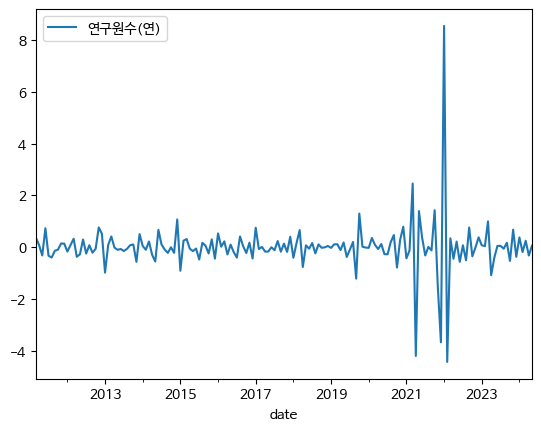

In [5]:
# feature 가 50개라서 나눠서 그래프 살펴봄
col = dfs.columns
dfs_s = dfs.iloc[:,1:2]
dfs_s.plot()


<Axes: xlabel='date'>

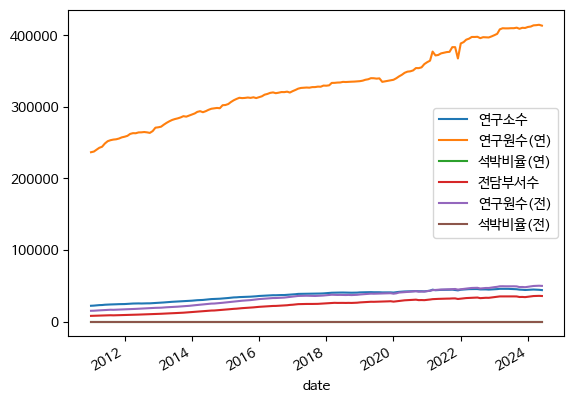

In [17]:
# data load
df_raw = pd.read_excel('../data/분석_데이터_목록_v2.xlsx', sheet_name='variable', index_col='date')
df_raw
df_raw_s = df_raw.iloc[:,0:6]
df_raw_s.plot()

[Text(0.0, 0, '연구소수'),
 Text(1.0, 0, '연구원수(연)'),
 Text(2.0, 0, '석박비율(연)'),
 Text(3.0, 0, '전담부서수'),
 Text(4.0, 0, '연구원수(전)'),
 Text(5.0, 0, '석박비율(전)'),
 Text(6.0, 0, '경제활동인구'),
 Text(7.0, 0, '취업자'),
 Text(8.0, 0, '비임금근로자'),
 Text(9.0, 0, '고용원이 있는 자영업자'),
 Text(10.0, 0, '고용원이 없는 자영업자'),
 Text(11.0, 0, '무급가족종사자'),
 Text(12.0, 0, '임금근로자'),
 Text(13.0, 0, '상용근로자'),
 Text(14.0, 0, '임시근로자'),
 Text(15.0, 0, '일용근로자'),
 Text(16.0, 0, '남자'),
 Text(17.0, 0, '여자'),
 Text(18.0, 0, '실업자'),
 Text(19.0, 0, '실업률'),
 Text(20.0, 0, '15세이상인구'),
 Text(21.0, 0, '비경제활동인구'),
 Text(22.0, 0, '경제활동참가율'),
 Text(23.0, 0, '고용률'),
 Text(24.0, 0, '경기종합지수_선행'),
 Text(25.0, 0, '경기종합지수_동행'),
 Text(26.0, 0, '전체산업'),
 Text(27.0, 0, '광공업'),
 Text(28.0, 0, '건설업'),
 Text(29.0, 0, '서비스업'),
 Text(30.0, 0, '공공행정'),
 Text(31.0, 0, '총수주액'),
 Text(32.0, 0, '국내수요'),
 Text(33.0, 0, '대리점'),
 Text(34.0, 0, '해외수요'),
 Text(35.0, 0, '총지수'),
 Text(36.0, 0, '설비투자지수'),
 Text(37.0, 0, '건설기성액'),
 Text(38.0, 0, '기업심리지수전망'),
 Text(39.0, 0, '업황전망

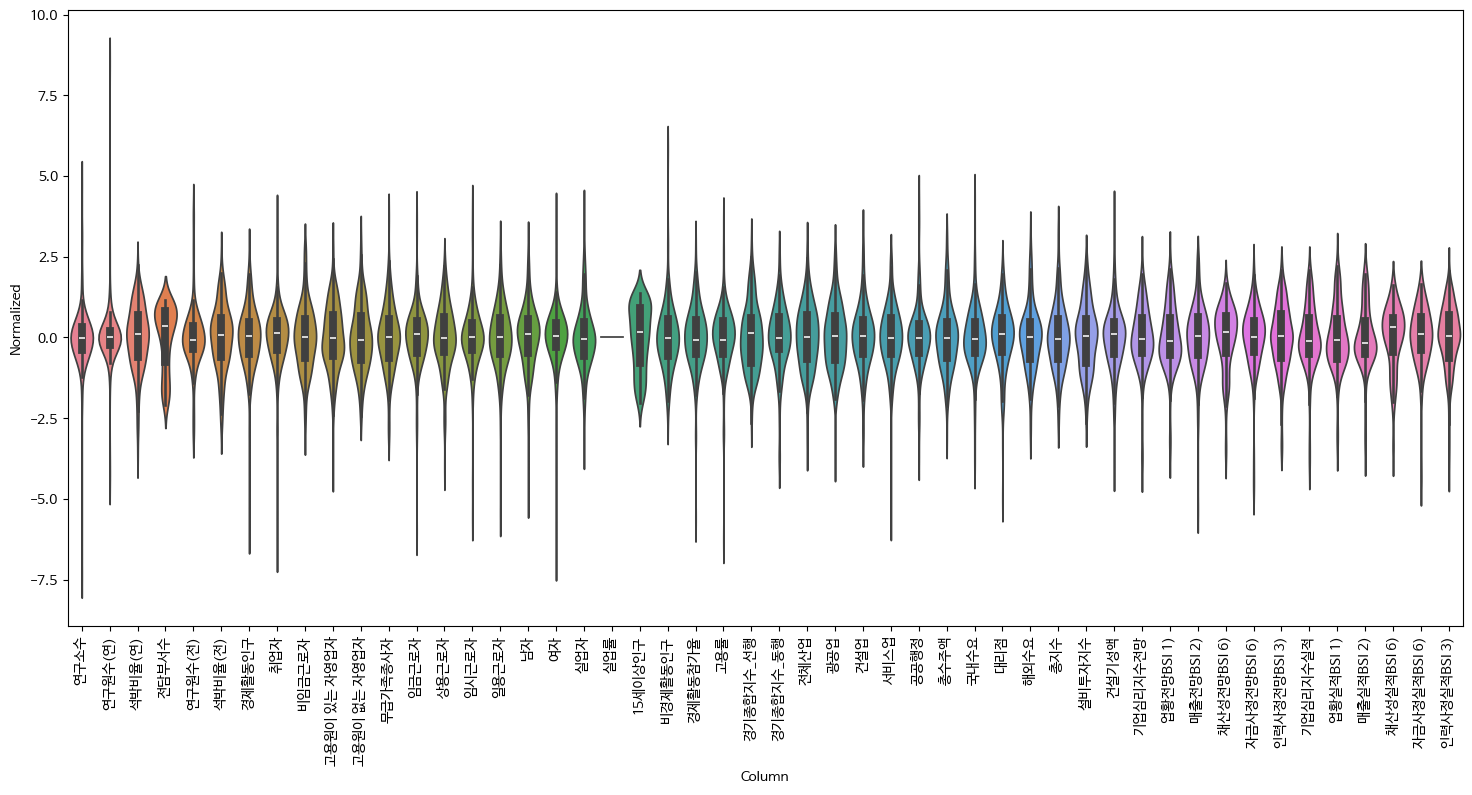

In [7]:
# 바이올린
dfss = dfs.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(18, 8))
ax = sns.violinplot(x='Column', y='Normalized', data=dfss, hue='Column')
ax.xaxis.set_ticks(dfs.keys())
ax.set_xticklabels(dfs.keys(), rotation=90)

[Text(0.0, 0, '연구소수'),
 Text(1.0, 0, '연구원수(연)'),
 Text(2.0, 0, '석박비율(연)'),
 Text(3.0, 0, '전담부서수'),
 Text(4.0, 0, '연구원수(전)'),
 Text(5.0, 0, '석박비율(전)'),
 Text(6.0, 0, '경제활동인구'),
 Text(7.0, 0, '취업자'),
 Text(8.0, 0, '비임금근로자'),
 Text(9.0, 0, '고용원이 있는 자영업자'),
 Text(10.0, 0, '고용원이 없는 자영업자'),
 Text(11.0, 0, '무급가족종사자'),
 Text(12.0, 0, '임금근로자'),
 Text(13.0, 0, '상용근로자'),
 Text(14.0, 0, '임시근로자'),
 Text(15.0, 0, '일용근로자'),
 Text(16.0, 0, '남자'),
 Text(17.0, 0, '여자'),
 Text(18.0, 0, '실업자'),
 Text(19.0, 0, '실업률'),
 Text(20.0, 0, '15세이상인구'),
 Text(21.0, 0, '비경제활동인구'),
 Text(22.0, 0, '경제활동참가율'),
 Text(23.0, 0, '고용률'),
 Text(24.0, 0, '경기종합지수_선행'),
 Text(25.0, 0, '경기종합지수_동행'),
 Text(26.0, 0, '전체산업'),
 Text(27.0, 0, '광공업'),
 Text(28.0, 0, '건설업'),
 Text(29.0, 0, '서비스업'),
 Text(30.0, 0, '공공행정'),
 Text(31.0, 0, '총수주액'),
 Text(32.0, 0, '국내수요'),
 Text(33.0, 0, '대리점'),
 Text(34.0, 0, '해외수요'),
 Text(35.0, 0, '총지수'),
 Text(36.0, 0, '설비투자지수'),
 Text(37.0, 0, '건설기성액'),
 Text(38.0, 0, '기업심리지수전망'),
 Text(39.0, 0, '업황전망

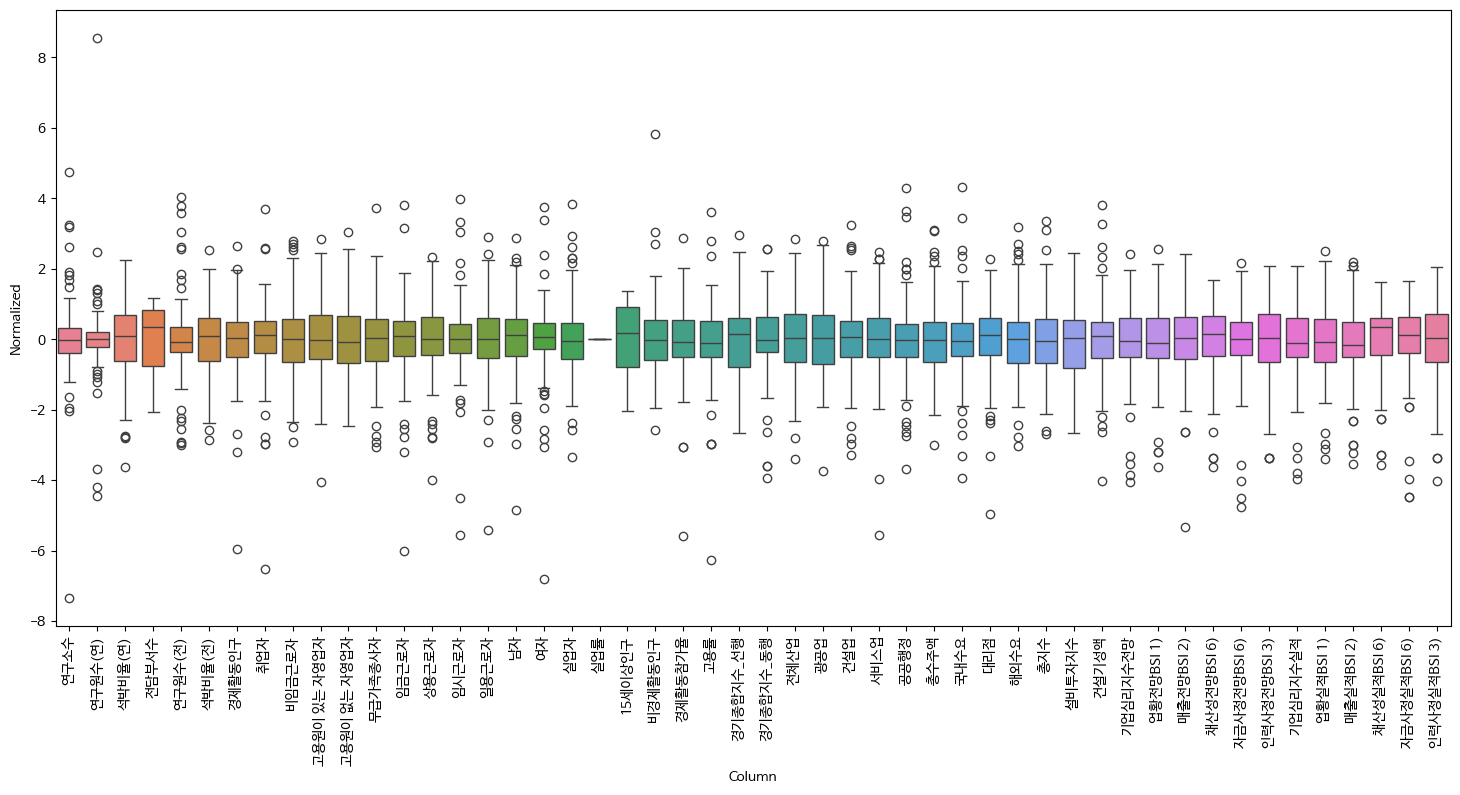

In [8]:
# boxplot
plt.figure(figsize=(18, 8))
ax = sns.boxplot(x='Column', y='Normalized', data=dfss, hue='Column')
ax.xaxis.set_ticks(dfs.keys())
ax.set_xticklabels(dfs.keys(), rotation=90)

- 실업률 컬럼에 대해서는 의미가 없기 때문에 drop 처리
- 요인추출 전 기본 측정 변수들에 대해서 상관계수 확인

In [209]:
print(f"drop col 전 컬럼 확인 : {dfs.columns}, col_len = {len(dfs.columns)}")
print(f"drop col '비임금근로자' : {cols[8]}")
print(f"drop col '고용원이 있 자영업자' : {cols[9]}")
print(f"drop col '고용원이 없는 자영업자' : {cols[10]}")
print(f"drop col '무급가족종사자' : {cols[11]}")
print(f"drop col '상용근로자' : {cols[13]}")
print(f"drop col '남자' : {cols[16]}")
print(f"drop col '여자' : {cols[17]}")
print(f"drop col '실업자' : {cols[18]}")
print(f"drop col '실업율' : {cols[19]}")
print(f"drop col '15세이상인구' : {cols[20]}")
print(f"drop col '비경제활동인구' : {cols[21]}")
print(f"drop col '경기종합지수_동행' : {cols[25]}")
print(f"drop col '서비스업' : {cols[29]}")
print(f"drop col '공공행정' : {cols[30]}")
print(f"drop col '국내수요' : {cols[32]}")
print(f"drop col '대리점' : {cols[33]}")
print(f"drop col '매출전망BSI 2)' : {cols[40]}")
print(f"drop col '인력사정전망BSI 3)' : {cols[43]}")
print(f"drop col '인력사정실적BSI 3)' : {cols[49]}")
dfsf = dfs.drop(labels=cols[[8,9,10,11,13,16,17,18,19,20,21,25,29,30,32,33,40,43,49]], axis=1)
print(f"drop col 후 컬럼 확인 : {dfsf.columns}, col_len = {len(dfsf.columns)}")

drop col 전 컬럼 확인 : Index(['연구소수', '연구원수(연)', '석박비율(연)', '전담부서수', '연구원수(전)', '석박비율(전)', '경제활동인구',
       '취업자', '비임금근로자', '고용원이 있는 자영업자', '고용원이 없는 자영업자', '무급가족종사자', '임금근로자',
       '상용근로자', '임시근로자', '일용근로자', '남자', '여자', '실업자', '실업률', '15세이상인구',
       '비경제활동인구', '경제활동참가율', '고용률', '경기종합지수_선행', '경기종합지수_동행', '전체산업', '광공업',
       '건설업', '서비스업', '공공행정', '총수주액', '국내수요', '대리점', '해외수요', '총지수', '설비투자지수',
       '건설기성액', '기업심리지수전망', '업황전망BSI 1)', '매출전망BSI 2)', '채산성전망BSI 6)',
       '자금사정전망BSI 6)', '인력사정전망BSI 3)', '기업심리지수실적', '업황실적BSI 1)', '매출실적BSI 2)',
       '채산성실적BSI 6)', '자금사정실적BSI 6)', '인력사정실적BSI 3)'],
      dtype='object'), col_len = 50
drop col '비임금근로자' : 비임금근로자
drop col '고용원이 있 자영업자' : 고용원이 있는 자영업자
drop col '고용원이 없는 자영업자' : 고용원이 없는 자영업자
drop col '무급가족종사자' : 무급가족종사자
drop col '상용근로자' : 상용근로자
drop col '남자' : 남자
drop col '여자' : 여자
drop col '실업자' : 실업자
drop col '실업율' : 실업률
drop col '15세이상인구' : 15세이상인구
drop col '비경제활동인구' : 비경제활동인구
drop col '경기종합지수_동행' : 경기종합지수_동행
drop col '서비스업' : 서비스업
drop col

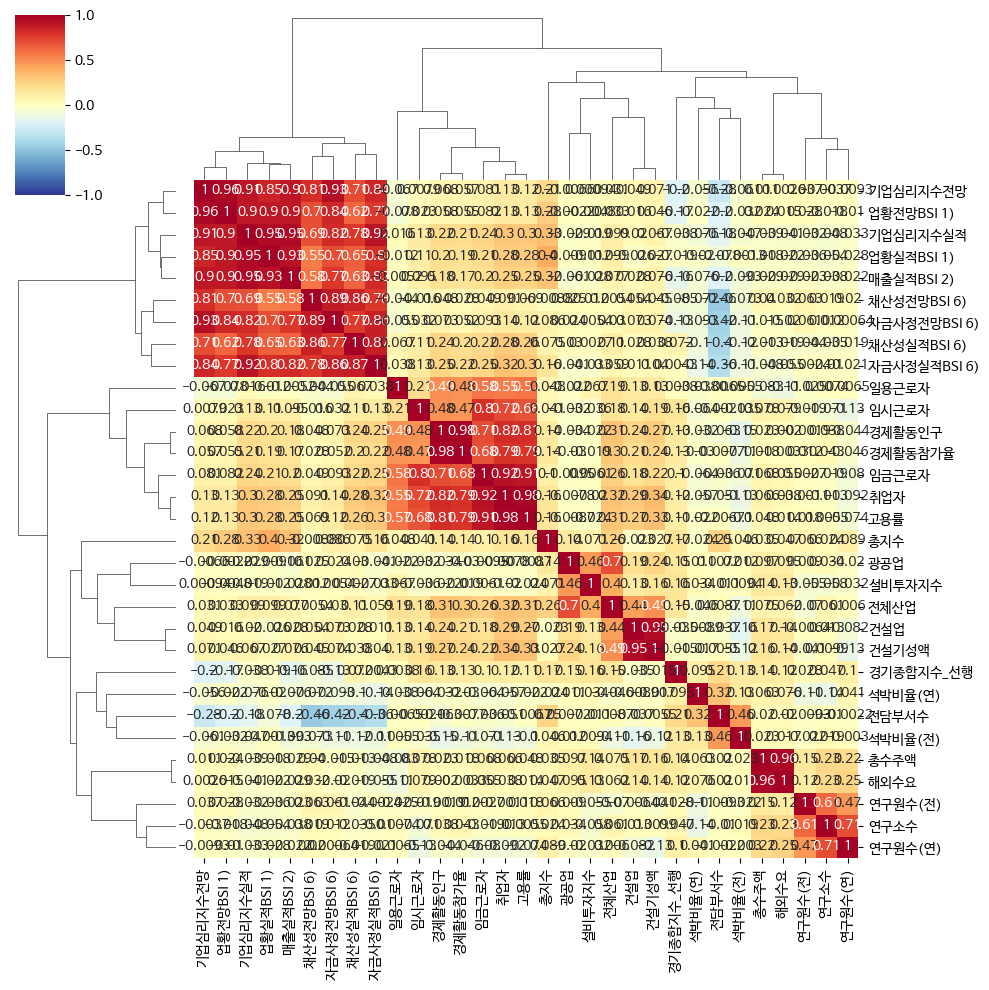

In [210]:
# 상관계수 확인 (요인추출 전)
cor_dfsf = dfsf.corr()
cor_dfsf # 차원이 49차원이라 눈으로 확인하기 어려움
sns.clustermap(cor_dfsf, 
               annot = True,      # 실제 값 화면에 나타내기
               cmap = 'RdYlBu_r',  # Red, Yellow, Blue 색상으로 표시
               vmin = -1, vmax = 1, #컬러차트 -1 ~ 1 범위로 표시
              )

In [19]:
ss_df = dfs.iloc[:,0:6]
ss_df.head()

,연구소수,연구원수(연),석박비율(연),전담부서수,연구원수(전),석박비율(전)
date,,,,,,
2011-03-01,0.473500,0.364054,-1.875678,-2.077731,0.588271,-2.070570
2011-04-01,-0.104368,0.077862,-0.262322,-2.043822,-0.295892,-0.134951
2011-05-01,-0.621238,-0.317886,-0.873642,-2.020106,-0.150470,-2.583862
2011-06-01,0.874798,0.732413,-2.802491,-1.982429,0.416674,1.521499
2011-07-01,-0.614818,-0.330420,-2.734148,-1.949954,-0.228998,-0.957904


- 요인분석 전 기초 위 상관관계 표에서도 3 ~ 5 정도의 요인으로 분류 될 것으로 예상됨.
- 이를 기초로 "EFA" 진행

In [ ]:
# from sklearn.cluster import KMeans
# kms = KMeans(n_clusters=5, init='k-means++', max_iter=300, random_state=0)
# kms.fit(dfsf)

### 3. 탐색적 요인 분석 (EFA) - 본격적 요인분석

    : 기존 app에서 사용한 기법을 위주로 시간 가능하면 주가 라이브러리들 고려 (24.09.25)
        -  

#### 3-1 요인분석 적합성 검정

 - Bartlett test
 - KMO(Kaiser-Meyer-Olkin) test

In [211]:
def normDist_test(data):
    chi_square_value,p_value=calculate_bartlett_sphericity(data)
    print(f"chi_square_value : {chi_square_value}")
    print(f"p_value() :{p_value}")

    kmo, p_value = calculate_kmo(data)
    print(f"kmo_all : {kmo}")
    print(f"kmo_model :{p_value}")


normDist_test(dfsf)

chi_square_value : 6564.102724022
p_value() :0.0
kmo_all : [0.56602552 0.60131284 0.40740028 0.57864693 0.63116974 0.62721176
 0.76253805 0.82465553 0.8466364  0.75012914 0.74164977 0.75865785
 0.83272765 0.46577153 0.73697973 0.57414749 0.5951442  0.52744296
 0.52370525 0.7233962  0.74660313 0.61895553 0.78681221 0.82240129
 0.84895037 0.85917459 0.7580461  0.81623562 0.83630338 0.82022723
 0.84966205]
kmo_model :0.7668248158176458


/home/augustine77/.cache/pypoetry/virtualenvs/scas-EkJwidcN-py3.11/lib/python3.11/site-packages/factor_analyzer/utils.py:244: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn(


- 기초 전체 요인으로 분석
- 전체 데이터에서는 eigenvalue 로 살펴볼 때 10~18 로 보임.

eigenvalue: 
 [8.23245806e+00 5.22970804e+00 2.78339620e+00 2.40652444e+00
 1.99561615e+00 1.62769776e+00 1.38068661e+00 1.06899094e+00
 9.37293787e-01 9.15330608e-01 7.75560931e-01 6.26889403e-01
 5.79321683e-01 5.26280776e-01 4.10976265e-01 3.13803453e-01
 2.43412259e-01 2.24094707e-01 1.90817198e-01 1.37269448e-01
 1.22564709e-01 6.44422612e-02 5.20112260e-02 3.82976099e-02
 3.08560533e-02 2.78854630e-02 2.13236003e-02 1.52444945e-02
 1.07242418e-02 6.84698596e-03 3.67462735e-03]


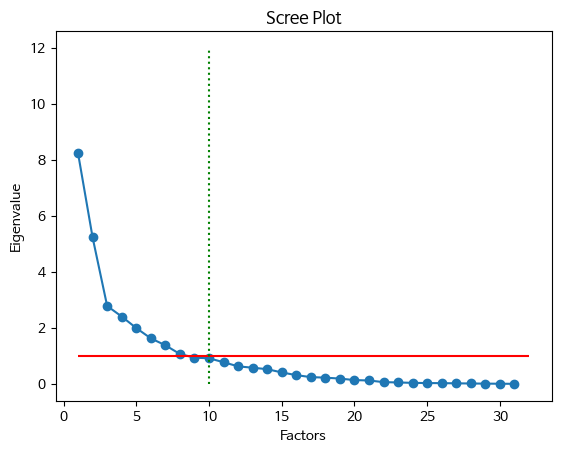

In [212]:
# 특성변수 전체 49개 진행
fa_base = FactorAnalyzer(n_factors=31,rotation=None)
fa_base.fit(dfsf)

#Eigen값 체크 
ev, v = fa_base.get_eigenvalues()
print(f"eigenvalue: \n {ev}")

plt.scatter(range(1,31 + 1),ev)
plt.plot(range(1,31 + 1),ev)
plt.hlines(1,1,31 + 1, colors='r')
plt.vlines(10,0,12, colors='g', ls=':')
plt.title('Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.show()

In [213]:

factor = 4
fa_01 = FactorAnalyzer(n_factors=factor, rotation="varimax") #ml : 최대우도 방법
fa_01.fit(dfsf)
efa_result = pd.DataFrame(fa_01.loadings_, index=dfsf.columns)
# efa_result


In [214]:
efa_rs = efa_result.round(3).sort_values(by=[k for k  in range(0,factor)],ascending=False)
# efa_rs
# efa_rs.to_excel("./result/efa_01.xlsx")

<Axes: >

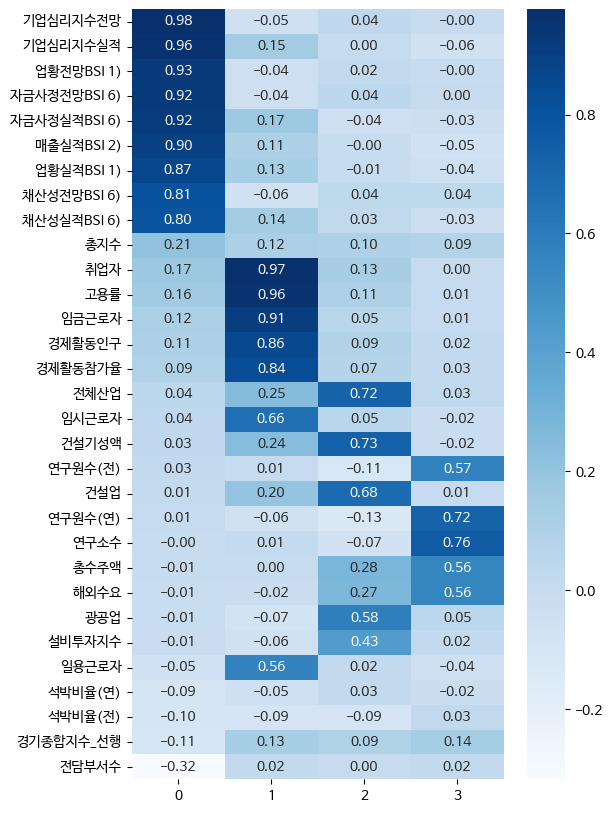

In [215]:
plt.figure(figsize=(6,10))
sns.heatmap(efa_rs, cmap="Blues", annot=True, fmt='.2f')

- 서비스업이 지수와 국내 고용 관련 지표 들과 상관관계가 높은 것은 우연일까?
- 전담부서와 석박사비율의 상관성과 관계가 없을까?

In [216]:
# 설명력
var = pd.DataFrame(fa_01.get_factor_variance(), index= ['SS-Loading','Proportion Var','Cumulative Var'])
var

# fa.fit_transform(X) ## 변환

,0,1,2,3
SS-Loading,7.557616,5.201985,2.314588,2.091457
Proportion Var,0.243794,0.167806,0.074664,0.067466
Cumulative Var,0.243794,0.411600,0.486264,0.553731


#### 연구소-전담 관련 컬럼으로 진행

In [186]:
# 검사
normDist_test(ss_df)

chi_square_value : 246.7642530661418
p_value() :5.756139268585269e-44
kmo_all : [0.59358678 0.62424174 0.46864044 0.52159793 0.75488535 0.53367573]
kmo_model :0.6045912744206907


eigenvalue: 
 [2.21324941 1.6294367  0.89349749 0.54856857 0.46971759 0.24553024]


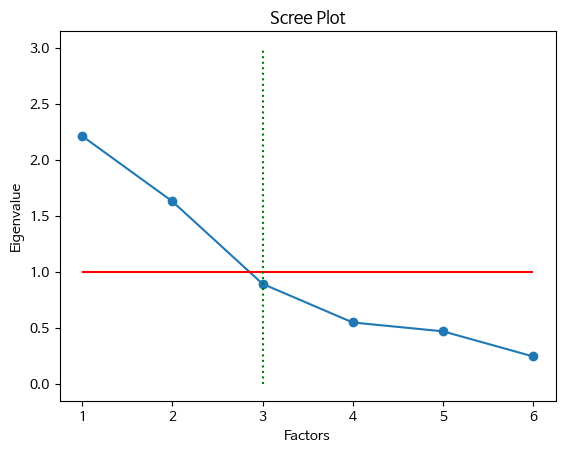

In [37]:
# 특성변수 전체 49개 진행
fa_ss = FactorAnalyzer(n_factors=6,rotation=None)
fa_ss.fit(ss_df)

#Eigen값 체크 
ev, v = fa_ss.get_eigenvalues()
print(f"eigenvalue: \n {ev}")

plt.scatter(range(1,7),ev)
plt.plot(range(1,7),ev)
plt.hlines(1,1,6, colors='r')
plt.vlines(3,0,3, colors='g', ls=':')
plt.title('Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.show()

<Axes: >

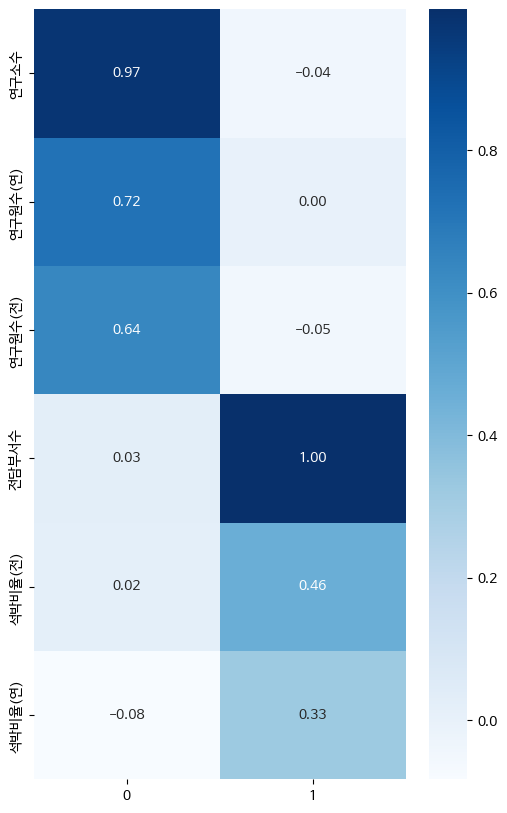

In [41]:
factor = 2

fa_ss01 = FactorAnalyzer(n_factors=factor, rotation="varimax") #ml : 최대우도 방법
fa_ss01.fit(ss_df)
ss_result = pd.DataFrame(fa_ss01.loadings_, index=ss_df.columns)

rs_ss = ss_result.round(3).sort_values(by=[k for k  in range(0,factor)],ascending=False)

plt.figure(figsize=(6,10))
sns.heatmap(rs_ss, cmap="Blues", annot=True, fmt='.2f')



In [34]:
# 설명력
ss_var = pd.DataFrame(fa_ss01.get_factor_variance(), index= ['SS-Loading','Proportion Var','Cumulative Var'])
ss_var

,0,1,2
SS-Loading,1.878273,1.015252,0.964364
Proportion Var,0.313045,0.169209,0.160727
Cumulative Var,0.313045,0.482254,0.642982


### scikit-learn - fa

<Axes: >

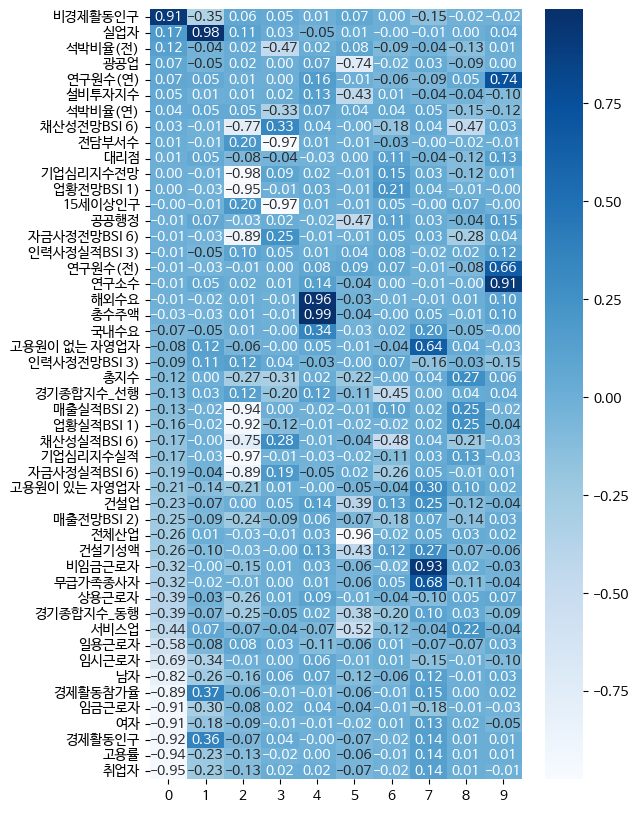

In [24]:
fa_02 = sk_FA(n_components=factor, rotation='varimax').fit(dfsf)
ff = pd.DataFrame(fa_02.components_)
efa_result_02 = ff.T
efa_result_02.index=dfsf.columns
efa_rs_02 = efa_result_02.round(3).sort_values(by=[k for k  in range(0,factor)],ascending=False)
plt.figure(figsize=(6,10))
sns.heatmap(efa_rs_02, cmap="Blues", annot=True, fmt='.2f')